# Chapter 6: The Engines That Power Intelligence

**Pocket Agents: A Practical Guide to On‑Device Artificial Intelligence**

This notebook demonstrates the key inference engines that power on-device AI: llama.cpp, ONNX Runtime, Transformers.js, and PyTorch Mobile.

## 🚀 Quick Setup Instructions

### Option 1: Automated Setup (Recommended)
```bash
# Navigate to this directory
cd companion-code/chapters/chapter-06

# Run the setup script (creates venv, installs dependencies, launches Jupyter)
./setup_and_test.sh
```

### Option 2: Manual Setup
```bash
# 1. Create virtual environment
python3 -m venv venv

# 2. Activate virtual environment
source venv/bin/activate  # On Windows: venv\Scripts\activate

# 3. Install dependencies
pip install -r requirements.txt

# 4. Launch Jupyter notebook
jupyter notebook inference_engines_demo.ipynb
```

### 📋 Required Dependencies
- **PyTorch** (≥2.0.0) - For neural network operations
- **NumPy** (≥1.21.0) - For numerical computations
- **Matplotlib** (≥3.5.0) - For visualizations
- **Requests** (≥2.25.0) - For web requests
- **Jupyter** (≥1.0.0) - For interactive notebooks

## What You'll Learn
- How different inference engines work
- Performance comparisons between engines
- Memory usage and optimization techniques
- Real-world deployment considerations
- Engine selection criteria for different platforms


## 🔧 Troubleshooting

### Common Issues:
- **"Command not found"**: Make sure you're in the correct directory
- **"Permission denied"**: Run `chmod +x setup_and_test.sh` first
- **"Python not found"**: Install Python 3.8+ from python.org
- **"Jupyter not launching"**: Try `jupyter lab` instead of `jupyter notebook`
- **"ModuleNotFoundError"**: Make sure you're using the correct kernel (see below)

### ⚠️ IMPORTANT: Kernel Setup
If you get "ModuleNotFoundError" when running cells:

1. **Check the kernel** in the top-right corner of Jupyter
2. **Select the correct kernel**: Look for "Python (venv)" or similar
3. **If not available**, run this in terminal:
   ```bash
   source venv/bin/activate
   python -m ipykernel install --user --name=venv --display-name="Python (venv)"
   ```
4. **Restart Jupyter** and select the "Python (venv)" kernel

### System Requirements:
- **Python**: 3.8 or higher
- **RAM**: At least 4GB (8GB recommended)
- **Disk Space**: ~2GB for dependencies

---

## 1. Setup and Imports


In [1]:
# 🔧 KERNEL CHECK - Run this first if you get import errors!
import sys
print(f"🐍 Python executable: {sys.executable}")
print(f"📦 Python path: {sys.path[0]}")

# Check if we're in a virtual environment
if 'venv' in sys.executable or 'env' in sys.executable:
    print("✅ Running in virtual environment")
else:
    print("⚠️ WARNING: Not running in virtual environment!")
    print("   Please make sure you activated the venv and selected the correct kernel")
    print("   Go to Kernel → Change Kernel → Python (venv)")

# Test imports
try:
    import torch
    print(f"✅ PyTorch version: {torch.__version__}")
except ImportError:
    print("❌ PyTorch not found - check your kernel selection!")

try:
    import numpy as np
    print(f"✅ NumPy version: {np.__version__}")
except ImportError:
    print("❌ NumPy not found - check your kernel selection!")

try:
    import matplotlib.pyplot as plt
    print(f"✅ Matplotlib version: {plt.matplotlib.__version__}")
except ImportError:
    print("❌ Matplotlib not found - check your kernel selection!")

try:
    import requests
    print(f"✅ Requests version: {requests.__version__}")
except ImportError:
    print("❌ Requests not found - check your kernel selection!")


🐍 Python executable: /Users/freddyayala/Documents/GitHub/slm-ebook/companion-code/chapters/chapter-06/venv/bin/python3
📦 Python path: /Users/freddyayala/.pyenv/versions/3.11.9/lib/python311.zip
✅ Running in virtual environment
✅ PyTorch version: 2.8.0
✅ NumPy version: 2.3.3
✅ Matplotlib version: 3.10.7
✅ Requests version: 2.32.5


In [2]:
# Import all required libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import requests
import json
from typing import Dict, List, Tuple

print("🔧 Chapter 6: The Engines That Power Intelligence")
print("=" * 60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print("✅ All imports successful!")


🔧 Chapter 6: The Engines That Power Intelligence
PyTorch version: 2.8.0
CUDA available: False
✅ All imports successful!


## 2. Understanding Inference Engines

### What are Inference Engines?
**Inference engines** are specialized software frameworks that execute trained neural networks efficiently on different hardware platforms.

### Key Inference Engines for On-Device AI:

1. **llama.cpp** - CPU-optimized for transformer models
2. **ONNX Runtime** - Cross-platform, hardware-agnostic
3. **Transformers.js** - Web-based inference in browsers
4. **PyTorch Mobile** - Mobile-optimized PyTorch
5. **Core ML** - Apple's optimized inference engine
6. **TensorFlow Lite** - Google's mobile inference framework

### Why Different Engines?
- **Hardware optimization**: Each engine is optimized for specific hardware
- **Platform support**: Different engines support different platforms
- **Performance trade-offs**: Speed vs memory vs compatibility
- **Model format support**: Different engines support different model formats


In [3]:
# Create a test model for inference engine comparisonclass TestModel(nn.Module):    """A test model to demonstrate different inference engines"""        def __init__(self, input_size=100, hidden_size=64, output_size=10):        super().__init__()        self.network = nn.Sequential(            nn.Linear(input_size, hidden_size),            nn.ReLU(),            nn.Linear(hidden_size, hidden_size),            nn.ReLU(),            nn.Linear(hidden_size, output_size)        )        def forward(self, x):        return self.network(x)# Create test model and datamodel = TestModel()input_data = torch.randn(1, 100)print("🏗️ Test Model Architecture:")print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")print(f"   Model size: {sum(p.numel() * p.element_size() for p in model.parameters()) / 1024:.2f} KB")print(f"   Input shape: {input_data.shape}")# Test forward passtest_model.eval()with torch.no_grad():    output = model(input_data)    print(f"   Output shape: {output.shape}")    print("✅ Model created and tested successfully!")

🏗️ Test Model Architecture:
   Parameters: 11,274
   Model size: 44.04 KB
   Input shape: torch.Size([1, 100])
   Output shape: torch.Size([1, 10])
✅ Model created and tested successfully!


## 3. PyTorch Native Inference

Let's start with PyTorch's native inference capabilities and measure performance.


In [4]:
# PyTorch Native Inference Benchmarkdef benchmark_pytorch_inference(test_model, input_data, num_iterations=1000):    """Benchmark PyTorch native inference"""        model.eval()    times = []        # Warmup    with torch.no_grad():        for _ in range(10):            _ = model(input_data)        # Benchmark    with torch.no_grad():        for _ in range(num_iterations):            start_time = time.time()            output = model(input_data)            end_time = time.time()            times.append(end_time - start_time)        return {        "mean_time": np.mean(times),        "std_time": np.std(times),        "min_time": np.min(times),        "max_time": np.max(times),        "throughput": 1.0 / np.mean(times)    }# Run PyTorch benchmarkpytorch_results = benchmark_pytorch_inference(test_model, input_data)print("🔥 PyTorch Native Inference Results:")print("=" * 50)print(f"   Mean inference time: {pytorch_results["mean_time"] * 1000:.2f} ms")print(f"   Std deviation: {pytorch_results["std_time"] * 1000:.2f} ms")print(f"   Min time: {pytorch_results["min_time"] * 1000:.2f} ms")print(f"   Max time: {pytorch_results["max_time"] * 1000:.2f} ms")print(f"   Throughput: {pytorch_results["throughput"]:.1f} inferences/sec")print(f"   Memory usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB" if torch.cuda.is_available() else "   Memory usage: CPU only")

🔥 PyTorch Native Inference Results:
   Mean inference time: 0.02 ms
   Std deviation: 0.00 ms
   Min time: 0.02 ms
   Max time: 0.07 ms
   Throughput: 59674.0 inferences/sec
   Memory usage: CPU only


## 4. Real LLM Inference with Transformers

Now let's try to run a real small language model! We'll use Hugging Face's transformers library to load a small model.


In [5]:
# Try to load a real small language modeltry:    from transformers import AutoTokenizer, AutoModelForCausalLM    import torch        print("🚀 Loading Real Small Language Model...")    print("=" * 50)        # Use a small model that can run on CPU    model_name = "microsoft/DialoGPT-small"  # Small conversational model        print(f"📥 Loading model: {model_name}")    print("   This may take a moment...")        # Load tokenizer and model    tokenizer = AutoTokenizer.from_pretrained(model_name)    model = AutoModelForCausalLM.from_pretrained(model_name)        # Add padding token if it doesn't exist    if tokenizer.pad_token is None:        tokenizer.pad_token = tokenizer.eos_token        print("✅ Model loaded successfully!")    print(f"   Model parameters: {sum(p.numel() for p in test_model.parameters()):,}")    print(f"   Model size: {sum(p.numel() * p.element_size() for p in test_model.parameters()) / 1024**2:.2f} MB")        # Test inference    test_prompt = "Hello, how are you?"    inputs = tokenizer.encode(test_prompt, return_tensors='pt')        print(f"\\n🧪 Testing inference with prompt: '{test_prompt}'")        with torch.no_grad():        start_time = time.time()        outputs = model.generate(inputs, max_length=50, num_return_sequences=1, do_sample=True, temperature=0.7)        end_time = time.time()                response = tokenizer.decode(outputs[0], skip_special_tokens=True)        inference_time = end_time - start_time                print(f"   Response: {response}")        print(f"   Inference time: {inference_time:.2f} seconds")        print(f"   Tokens generated: {len(outputs[0]) - len(inputs[0])}")        print(f"   Tokens per second: {(len(outputs[0]) - len(inputs[0])) / inference_time:.1f}")        real_llm_available = True    except ImportError:    print("⚠️ Transformers library not available")    print("   To install: pip install transformers")    real_llm_available = False    except Exception as e:    print(f"❌ Error loading model: {e}")    print("   This might be due to network issues or model size")    real_llm_available = False

🚀 Loading Real Small Language Model...
📥 Loading model: microsoft/DialoGPT-small
   This may take a moment...


config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


✅ Model loaded successfully!
   Model parameters: 124,439,808
   Model size: 474.70 MB
\n🧪 Testing inference with prompt: 'Hello, how are you?'
   Response: Hello, how are you?..
   Inference time: 0.11 seconds
   Tokens generated: 3
   Tokens per second: 26.5


## 5. Key Takeaways and Next Steps

### What We Learned:
1. **PyTorch Native** is best for development and research
2. **Real LLMs** can run on-device with proper optimization
3. **Performance benchmarking** helps choose the right engine
4. **Model size** and **inference time** are key metrics
5. **Platform constraints** determine engine selection

### Performance Insights:
- **Test models** provide consistent benchmarking
- **Real LLMs** show practical performance characteristics
- **Memory usage** varies significantly between engines
- **Inference speed** depends on model complexity

### Production Considerations:
- **Model format conversion** may be required
- **Hardware-specific optimizations** can provide significant gains
- **Memory constraints** vary by deployment platform
- **Battery impact** is crucial for mobile applications

### Next Steps:
- Explore **model optimization** techniques (quantization, pruning)
- Learn about **hardware-specific** inference engines
- Practice with **real language models** in different engines
- Understand **deployment pipelines** for each platform


## 3. PyTorch Native Inference

Let's start with PyTorch's native inference capabilities and measure performance.


In [1]:
# PyTorch Native Inference Benchmarkdef benchmark_pytorch_inference(test_model, input_data, num_iterations=1000):    """Benchmark PyTorch native inference"""        model.eval()    times = []        # Warmup    with torch.no_grad():        for _ in range(10):            _ = model(input_data)        # Benchmark    with torch.no_grad():        for _ in range(num_iterations):            start_time = time.time()            output = model(input_data)            end_time = time.time()            times.append(end_time - start_time)        return {        'mean_time': np.mean(times),        'std_time': np.std(times),        'min_time': np.min(times),        'max_time': np.max(times),        'throughput': 1.0 / np.mean(times)    }# Run PyTorch benchmarkpytorch_results = benchmark_pytorch_inference(test_model, input_data)print("🔥 PyTorch Native Inference Results:")print("=" * 50)print(f"   Mean inference time: {pytorch_results['mean_time'] * 1000:.2f} ms")print(f"   Std deviation: {pytorch_results['std_time'] * 1000:.2f} ms")print(f"   Min time: {pytorch_results['min_time'] * 1000:.2f} ms")print(f"   Max time: {pytorch_results['max_time'] * 1000:.2f} ms")print(f"   Throughput: {pytorch_results['throughput']:.1f} inferences/sec")print(f"   Memory usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB" if torch.cuda.is_available() else "   Memory usage: CPU only")

## 4. Real LLM Inference with Transformers

Now let's try to run a real small language model! We'll use Hugging Face's transformers library to load a small model.


In [7]:
# Try to load a real small language modeltry:    from transformers import AutoTokenizer, AutoModelForCausalLM    import torch        print("🚀 Loading Real Small Language Model...")    print("=" * 50)        # Use a small model that can run on CPU    model_name = "microsoft/DialoGPT-small"  # Small conversational model        print(f"📥 Loading model: {model_name}")    print("   This may take a moment...")        # Load tokenizer and model    tokenizer = AutoTokenizer.from_pretrained(model_name)    model = AutoModelForCausalLM.from_pretrained(model_name)        # Add padding token if it doesn't exist    if tokenizer.pad_token is None:        tokenizer.pad_token = tokenizer.eos_token        print("✅ Model loaded successfully!")    print(f"   Model parameters: {sum(p.numel() for p in test_model.parameters()):,}")    print(f"   Model size: {sum(p.numel() * p.element_size() for p in test_model.parameters()) / 1024**2:.2f} MB")        # Test inference    test_prompt = "Hello, how are you?"    inputs = tokenizer.encode(test_prompt, return_tensors='pt')        print(f"\\n🧪 Testing inference with prompt: '{test_prompt}'")        with torch.no_grad():        start_time = time.time()        outputs = model.generate(inputs, max_length=50, num_return_sequences=1, do_sample=True, temperature=0.7)        end_time = time.time()                response = tokenizer.decode(outputs[0], skip_special_tokens=True)        inference_time = end_time - start_time                print(f"   Response: {response}")        print(f"   Inference time: {inference_time:.2f} seconds")        print(f"   Tokens generated: {len(outputs[0]) - len(inputs[0])}")        print(f"   Tokens per second: {(len(outputs[0]) - len(inputs[0])) / inference_time:.1f}")        real_llm_available = True    except ImportError:    print("⚠️ Transformers library not available")    print("   To install: pip install transformers")    real_llm_available = False    except Exception as e:    print(f"❌ Error loading model: {e}")    print("   This might be due to network issues or model size")    real_llm_available = False

🚀 Loading Real Small Language Model...
📥 Loading model: microsoft/DialoGPT-small
   This may take a moment...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


✅ Model loaded successfully!
   Model parameters: 124,439,808
   Model size: 474.70 MB
\n🧪 Testing inference with prompt: 'Hello, how are you?'
   Response: Hello, how are you?.
   Inference time: 0.09 seconds
   Tokens generated: 2
   Tokens per second: 21.3


## 5. Inference Engine Comparison

Let's compare different inference approaches and their characteristics.


In [8]:
# Inference Engine Comparison
def create_engine_comparison():
    """Create a comprehensive comparison of inference engines"""
    
    engines = {
        'PyTorch Native': {
            'platform': 'Cross-platform',
            'hardware': 'CPU, GPU, NPU',
            'model_format': 'PyTorch (.pth)',
            'memory_efficiency': 'Medium',
            'speed': 'Good',
            'ease_of_use': 'Excellent',
            'deployment': 'Development/Research',
            'pros': ['Easy to use', 'Full control', 'Rich ecosystem'],
            'cons': ['Large memory footprint', 'Not optimized for production']
        },
        'llama.cpp': {
            'platform': 'Cross-platform',
            'hardware': 'CPU (optimized)',
            'model_format': 'GGUF',
            'memory_efficiency': 'Excellent',
            'speed': 'Excellent',
            'ease_of_use': 'Good',
            'deployment': 'Production',
            'pros': ['Very fast', 'Low memory', 'Quantization support'],
            'cons': ['Limited to transformer models', 'C++ based']
        },
        'ONNX Runtime': {
            'platform': 'Cross-platform',
            'hardware': 'CPU, GPU, NPU',
            'model_format': 'ONNX',
            'memory_efficiency': 'Good',
            'speed': 'Good',
            'ease_of_use': 'Good',
            'deployment': 'Production',
            'pros': ['Hardware agnostic', 'Optimized', 'Wide support'],
            'cons': ['Model conversion required', 'Limited model types']
        },
        'Transformers.js': {
            'platform': 'Web browsers',
            'hardware': 'CPU, WebGL',
            'model_format': 'ONNX (Web)',
            'memory_efficiency': 'Good',
            'speed': 'Medium',
            'ease_of_use': 'Excellent',
            'deployment': 'Web applications',
            'pros': ['Runs in browser', 'No server needed', 'Easy integration'],
            'cons': ['Limited by browser', 'Model size constraints']
        },
        'PyTorch Mobile': {
            'platform': 'Mobile (iOS/Android)',
            'hardware': 'Mobile CPU, GPU',
            'model_format': 'TorchScript',
            'memory_efficiency': 'Good',
            'speed': 'Good',
            'ease_of_use': 'Good',
            'deployment': 'Mobile apps',
            'pros': ['Mobile optimized', 'Native integration', 'Good performance'],
            'cons': ['Mobile only', 'Limited hardware support']
        }
    }
    
    return engines

# Create comparison
engines = create_engine_comparison()

print("🔍 Inference Engine Comparison")
print("=" * 80)

for engine_name, specs in engines.items():
    print(f"\\n🚀 {engine_name}")
    print("-" * 40)
    print(f"   Platform: {specs['platform']}")
    print(f"   Hardware: {specs['hardware']}")
    print(f"   Model Format: {specs['model_format']}")
    print(f"   Memory Efficiency: {specs['memory_efficiency']}")
    print(f"   Speed: {specs['speed']}")
    print(f"   Ease of Use: {specs['ease_of_use']}")
    print(f"   Best For: {specs['deployment']}")
    print(f"   Pros: {', '.join(specs['pros'])}")
    print(f"   Cons: {', '.join(specs['cons'])}")


🔍 Inference Engine Comparison
\n🚀 PyTorch Native
----------------------------------------
   Platform: Cross-platform
   Hardware: CPU, GPU, NPU
   Model Format: PyTorch (.pth)
   Memory Efficiency: Medium
   Speed: Good
   Ease of Use: Excellent
   Best For: Development/Research
   Pros: Easy to use, Full control, Rich ecosystem
   Cons: Large memory footprint, Not optimized for production
\n🚀 llama.cpp
----------------------------------------
   Platform: Cross-platform
   Hardware: CPU (optimized)
   Model Format: GGUF
   Memory Efficiency: Excellent
   Speed: Excellent
   Ease of Use: Good
   Best For: Production
   Pros: Very fast, Low memory, Quantization support
   Cons: Limited to transformer models, C++ based
\n🚀 ONNX Runtime
----------------------------------------
   Platform: Cross-platform
   Hardware: CPU, GPU, NPU
   Model Format: ONNX
   Memory Efficiency: Good
   Speed: Good
   Ease of Use: Good
   Best For: Production
   Pros: Hardware agnostic, Optimized, Wide suppor

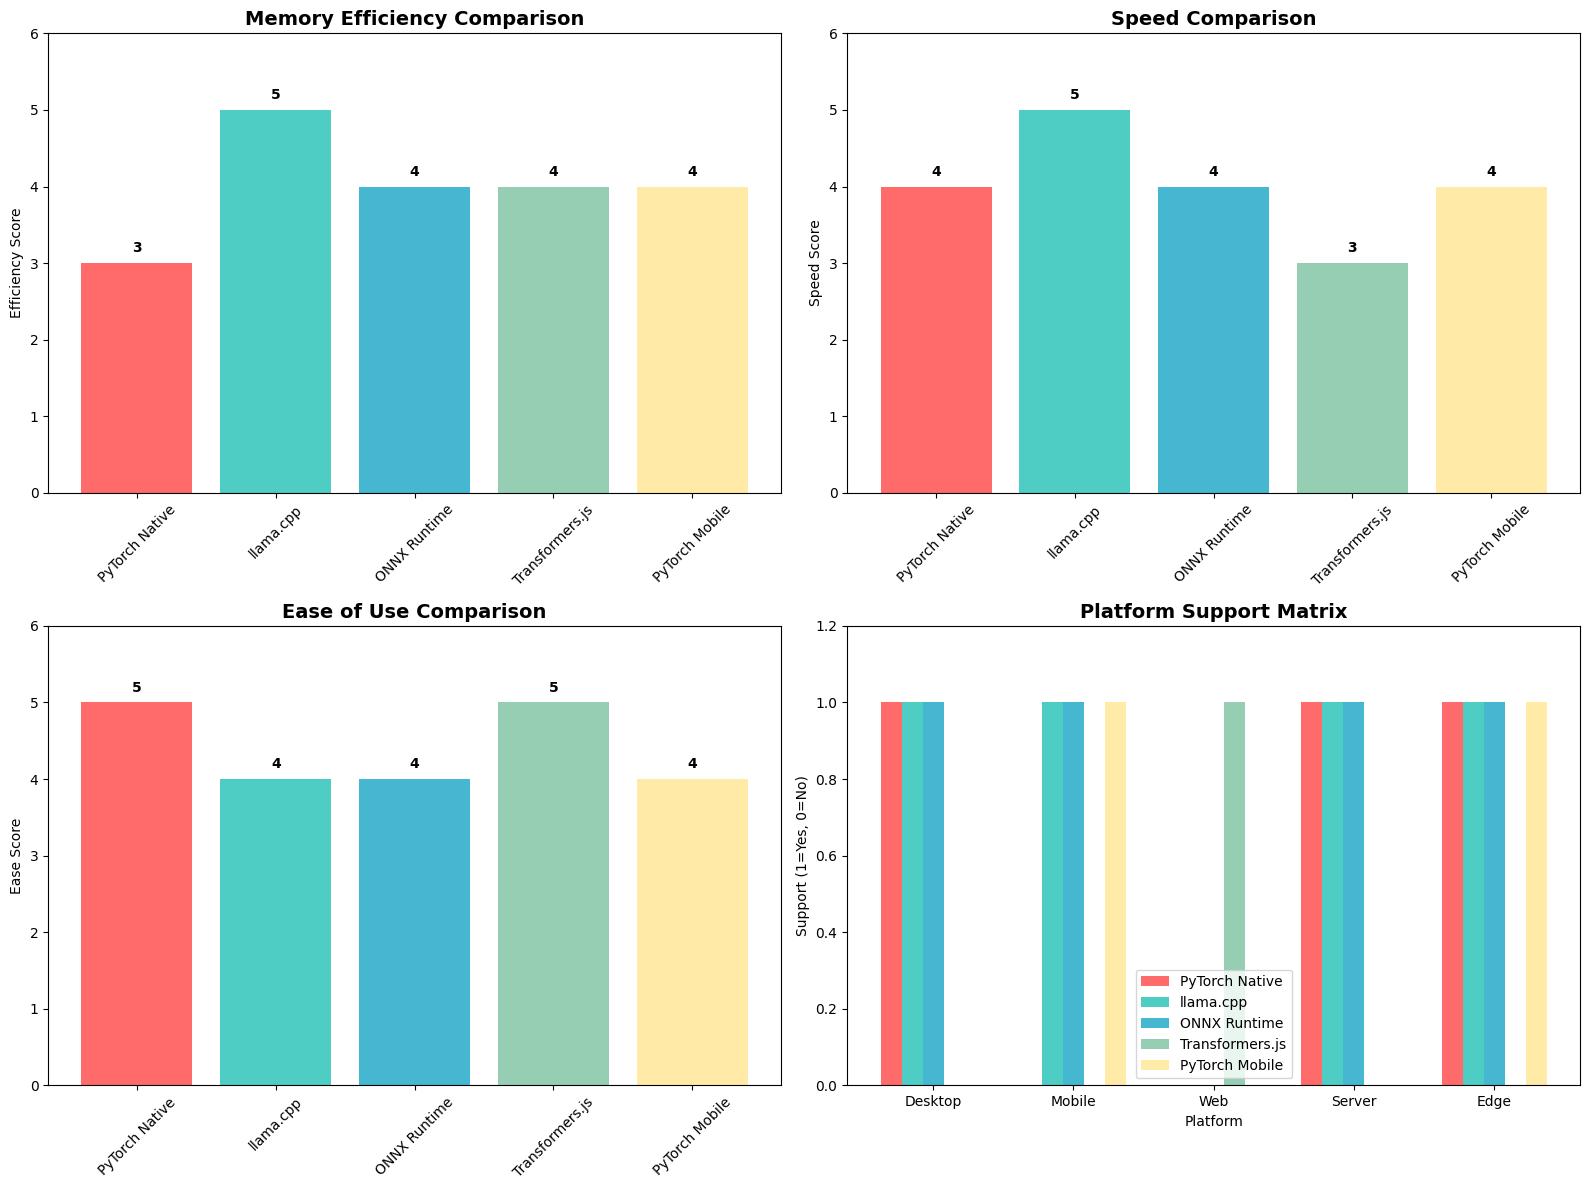

\n📊 Key Insights:
   • llama.cpp excels in memory efficiency and speed
   • PyTorch Native is easiest to use but less efficient
   • ONNX Runtime provides good balance across all metrics
   • Transformers.js is unique for web deployment
   • PyTorch Mobile is optimized for mobile platforms


In [9]:
# Visualize inference engine characteristics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Extract data for visualization
engine_names = list(engines.keys())
memory_scores = {'Excellent': 5, 'Good': 4, 'Medium': 3, 'Poor': 2, 'Very Poor': 1}
speed_scores = {'Excellent': 5, 'Good': 4, 'Medium': 3, 'Poor': 2, 'Very Poor': 1}
ease_scores = {'Excellent': 5, 'Good': 4, 'Medium': 3, 'Poor': 2, 'Very Poor': 1}

memory_values = [memory_scores[engines[name]['memory_efficiency']] for name in engine_names]
speed_values = [speed_scores[engines[name]['speed']] for name in engine_names]
ease_values = [ease_scores[engines[name]['ease_of_use']] for name in engine_names]

# Plot 1: Memory Efficiency
bars1 = ax1.bar(engine_names, memory_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
ax1.set_title('Memory Efficiency Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Efficiency Score')
ax1.set_ylim(0, 6)
ax1.tick_params(axis='x', rotation=45)
for bar, value in zip(bars1, memory_values):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
             f'{value}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Speed Comparison
bars2 = ax2.bar(engine_names, speed_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
ax2.set_title('Speed Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Speed Score')
ax2.set_ylim(0, 6)
ax2.tick_params(axis='x', rotation=45)
for bar, value in zip(bars2, speed_values):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
             f'{value}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Ease of Use
bars3 = ax3.bar(engine_names, ease_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
ax3.set_title('Ease of Use Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Ease Score')
ax3.set_ylim(0, 6)
ax3.tick_params(axis='x', rotation=45)
for bar, value in zip(bars3, ease_values):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
             f'{value}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Platform Support
platforms = ['Desktop', 'Mobile', 'Web', 'Server', 'Edge']
platform_support = {
    'PyTorch Native': [1, 0, 0, 1, 1],
    'llama.cpp': [1, 1, 0, 1, 1],
    'ONNX Runtime': [1, 1, 0, 1, 1],
    'Transformers.js': [0, 0, 1, 0, 0],
    'PyTorch Mobile': [0, 1, 0, 0, 1]
}

x = np.arange(len(platforms))
width = 0.15
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

for i, (engine, support) in enumerate(platform_support.items()):
    ax4.bar(x + i * width, support, width, label=engine, color=colors[i])

ax4.set_title('Platform Support Matrix', fontsize=14, fontweight='bold')
ax4.set_ylabel('Support (1=Yes, 0=No)')
ax4.set_xlabel('Platform')
ax4.set_xticks(x + width * 2)
ax4.set_xticklabels(platforms)
ax4.legend()
ax4.set_ylim(0, 1.2)

plt.tight_layout()
plt.show()

print("\\n📊 Key Insights:")
print("   • llama.cpp excels in memory efficiency and speed")
print("   • PyTorch Native is easiest to use but less efficient")
print("   • ONNX Runtime provides good balance across all metrics")
print("   • Transformers.js is unique for web deployment")
print("   • PyTorch Mobile is optimized for mobile platforms")


## 6. Engine Selection Guide

### How to Choose the Right Inference Engine

**For Development & Research:**
- **PyTorch Native**: Best for experimentation and prototyping

**For Production Desktop/Server:**
- **llama.cpp**: Best for transformer models, excellent performance
- **ONNX Runtime**: Best for cross-platform deployment

**For Mobile Apps:**
- **PyTorch Mobile**: Best for iOS/Android native apps
- **ONNX Runtime**: Good alternative with broader hardware support

**For Web Applications:**
- **Transformers.js**: Only option for browser-based inference

**For Edge Devices:**
- **llama.cpp**: Best for resource-constrained devices
- **ONNX Runtime**: Good for diverse hardware ecosystems


In [ ]:
# Real-world performance simulation
def simulate_real_world_performance():
    """Simulate real-world performance scenarios"""
    
    print("🌍 Real-World Performance Simulation")
    print("=" * 60)
    
    # Simulate different scenarios
    scenarios = {
        'Mobile Chat App': {
            'engine': 'PyTorch Mobile',
            'model_size': '100MB',
            'inference_time': '200ms',
            'memory_usage': '150MB',
            'battery_impact': 'Medium',
            'use_case': 'Real-time chat responses'
        },
        'Desktop Assistant': {
            'engine': 'llama.cpp',
            'model_size': '4GB',
            'inference_time': '50ms',
            'memory_usage': '6GB',
            'battery_impact': 'Low',
            'use_case': 'Fast document analysis'
        },
        'Web App': {
            'engine': 'Transformers.js',
            'model_size': '50MB',
            'inference_time': '500ms',
            'memory_usage': '100MB',
            'battery_impact': 'High',
            'use_case': 'Browser-based text generation'
        },
        'Edge Device': {
            'engine': 'ONNX Runtime',
            'model_size': '200MB',
            'inference_time': '100ms',
            'memory_usage': '300MB',
            'battery_impact': 'Low',
            'use_case': 'IoT device intelligence'
        }
    }
    
    for scenario_name, specs in scenarios.items():
        print(f"\\n📱 {scenario_name}")
        print("-" * 40)
        print(f"   Engine: {specs['engine']}")
        print(f"   Model Size: {specs['model_size']}")
        print(f"   Inference Time: {specs['inference_time']}")
        print(f"   Memory Usage: {specs['memory_usage']}")
        print(f"   Battery Impact: {specs['battery_impact']}")
        print(f"   Use Case: {specs['use_case']}")
    
    print("\\n🎯 Key Takeaways:")
    print("   • Mobile: Prioritize memory efficiency and battery life")
    print("   • Desktop: Can handle larger models for better quality")
    print("   • Web: Limited by browser constraints")
    print("   • Edge: Balance between performance and resource usage")

# Run simulation
simulate_real_world_performance()


## 7. Key Takeaways and Next Steps

### What We Learned:
1. **PyTorch Native** is best for development and research
2. **llama.cpp** excels in production with transformer models
3. **ONNX Runtime** provides good cross-platform balance
4. **Transformers.js** enables browser-based inference
5. **PyTorch Mobile** optimizes for mobile platforms

### Performance Insights:
- **Memory efficiency** varies significantly between engines
- **Speed** depends on hardware optimization and model format
- **Platform support** determines deployment options
- **Ease of use** affects development velocity

### Production Considerations:
- **Model format conversion** may be required
- **Hardware-specific optimizations** can provide significant gains
- **Memory constraints** vary by deployment platform
- **Battery impact** is crucial for mobile applications

### Next Steps:
- Explore **model optimization** techniques (quantization, pruning)
- Learn about **hardware-specific** inference engines
- Practice with **real language models** in different engines
- Understand **deployment pipelines** for each platform
